# **STAT 315 Final Project**

## **Project Introduction:**

---

Our project will build on our earlier report by examining how population growth differs across countries, regions, and income groups, whether countries with slow growth show signs of long-term decline, and how resampling can help measure uncertainty in these trends.

Using the same **World Population** dataset from the mini-visualization assignment, we will clean and store a complete version in our GitHub repository, ensure population values and country attributes align across all years, document how the data was obtained, and format it into a long table layout suitable for time-series analysis.


## **Defining Key Question(s):**

---
**Overarching Question:** How have global population trends evolved across countries, regions, and income groups over time, and to what extent can we quantify uncertainty in these growth patterns and future projections?

**Subquestions:**
1.   How does population growth vary across individual countries over time?
2.   How do regional population growth trends differ?
3.   How do population growth rates (CAGR) differ across major World Bank income groups (e.g, low, lower-middle, high)
4.   Which countries show the fastest and slowest population growth over a span of 20 years?
5.   Do countries with slow population growth show consistent future population decline over the next 5 years?
6.   Do regional and income group patterns remain consistent after bootstrapping resampling?
7.   How does bootstrapping help measure uncertainty in overall population growth trends across countries, regions, and income groups?





## **Data Collection:**

In [1]:
# Import Statements
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# Creating two Pandas Dataframes:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
world_pop_df = pd.read_csv("./data/world_pop_data.csv")
country_df = pd.read_csv("./data/country_data.csv")

## **Data Collection Analysis:**

### **General Dataset Information:**

The dataset used in this project originates from the public Datalab repository called **World Population Data**. This repository consists of two datasets which have compiled and extracted updated data from World Bank's **World Development Indicators** (WDI). These indicators have been compiled from various sources such as the United Nation's statistical offices and registers. Since the World Bank aggregates information from official governmental and international statistical agencies, the repository is considered as a reliable, globally standardized source for demographic analysis.

The specific indicator used from this dataset is "**Population, Total**" (WDI code: **SP.POP.TOTL**). This represents the total population living in a country or territory during a given year. This statistic is a complete population count and values are recorded annually. The dataset's timeframe spans from 1960 to 2020, thereby representing a total of 6 decades, although the exact coverage varies by country/region based on census timing.


---

### **Dataset Features / Variable Descriptions:**

**Population Table (world_pop_df):**

*   Country Code (ISO 3-letter): String; Unique key for merging datasets
*   Indicator Name: String; Set to "Population, total" for all rows
*   Indicator Code: String; used to identify "SP.POP.TOTL"
*   Year columns (1960, 1961, ... , 2020): Numeric; integer population counts

**Country Metadata Table (country_df):**

*   Country Code (ISO 3-letter): String; Unique key for merging datasets
*   Region: String; (e.g. South Asia, Europe)
*   IncomeGroup: String; (e.g. Low, Low-Middle, High)
*   TableName: String; Country names (e.g. Angola, Aruba)
*   SpecialNotes: String; detailed information about certain regions/demographics


**Variable Types:**

*   **Numerical**: All population columns (int)
*   **Categorical**: Region, IncomeGroup
*   **String Identifiers**: Country Code/Name, Indicator Code/Name
*   **Time-Series**: Each year column in population dataset consists of one unique timestamp per country


---


### **Population / Timeframe Context:**

The dataset captures over 6 decades of demographic change across major global countries and regions. Since population statistics vary widely across these geographic regions, the dataset enables us to conduct high-quality analysis of country-specific population trends, cross-regional and income-level disparities, and long-term forecasting.

---


### **Source Citations:**



1.   “World Population Prospects 2024.” United Nations, United Nations, population.un.org/wpp/. Accessed 5 Dec. 2025.
2.   “UNSD - Partners.” United Nations, United Nations, unstats.un.org/home/nso_sites/. Accessed 5 Dec. 2025.
3.   “Structure of Earnings Survey: Monthly Earnings (Earn_ses_monthly).” Database - Eurostat, Eurostat, ec.europa.eu/eurostat/data/database?node_code=earn_ses_monthly. Accessed 5 Dec. 2025.  
4.   “UNSD - Welcome to UNSD.” United Nations, United Nations, unstats.un.org/UNSDWebsite/. Accessed 5 Dec. 2025.

## **Data Cleaning and Preparation:**

In [4]:
# Step 1: Identify Time-Series Columns (Year)
year_cols = [c for c in world_pop_df.columns if isinstance(c, str) and c.isdigit() and len(c) == 4]
year_cols = sorted(year_cols)

In [5]:
# Step 2: Filter rows to contain only the "Population, Total" or "SP.POP.TOTL" Indicators
if "Indicator Name" in world_pop_df.columns:
    # Common names to match (case-insensitive)
    mask_total = world_pop_df["Indicator Name"].str.contains("Population, total", case=False, na=False) | \
                 world_pop_df["Indicator Name"].str.contains("SP.POP.TOTL", case=False, na=False)
    if mask_total.any():
        pop_total = world_pop_df.loc[mask_total].copy()
    else:
        # Fall back to assuming the dataset is already population totals
        pop_total = world_pop_df.copy()
else:
    pop_total = world_pop_df.copy()


In [6]:
# Step 3: Convert the original world pop. data from Wide format to Long format
long = pop_total.melt(id_vars=[c for c in pop_total.columns if c not in year_cols],
                      value_vars=year_cols, var_name="year", value_name="population")
# long

In [7]:
# step 4: Converting "year" and "population" columns into numeric data types
long["year"] = pd.to_numeric(long["year"], errors="coerce")
long["population"] = pd.to_numeric(long["population"], errors="coerce")

# long

In [8]:
# step 5: Create a simplified version of the country_data to contain only
# columns such as "Country Code", "Region", "IncomeGroup", and "TableName". Renames the "TableName" col to "Country"
# for better clarity and "IncomeGroup" to "Income_Group" for consistency
country_df_simplified = country_df[["Country Code", "Region", "IncomeGroup", "TableName"]].rename(
columns={"TableName": "Country", "IncomeGroup": "Income_Group"})
# country_df_simplified

In [9]:
# Step 6: Merge both the tables together to form one combined table that contains all information
long = long.merge(country_df_simplified, on="Country Code", how="left")
# long.head(20)

In [10]:
# Step 7: Basic cleaning: drop aggregates or missing names/regions for now
final_df = long.dropna(subset=["Country", "Income_Group"]).copy()
# final_df.head(20)

## **Data Cleaning and Preparation Analysis:**

### **Comprehensive Outlook:**

The cleaning and preparation process ensured that the dataset was consistent, complete, and relevant. All the following steps were designed to be feature-specific, precise, and loss-minimizing.


---

**Step 1: Selecting Relevant Data:**

The first pre-processing step of the cleaning process was to ensure that only the "Population, Total" indicator is being considered across all rows for each country. This ensured that the dataset contained only one observation for each country per year.

**Step 2: Identifying Valid Year Columns:**

Since the raw world population dataset consisted of both metadata columns and year columns, all the columns were first scanned and then filtered to select only the year columns. Each year column was identified by the following **three conditions**:

1. Is a string
2. Can be represented as a numeric digit
3. Strictly 4 characters long


**Step 3: Handling Missingness:**

**Missing Year Values:**

Countries that lack certain population counts are preserved in the dataset. Later analysis will evaluate trends on only existing data points.

**Missing Region/Income Data:**

In the country dataset, countries lacking region or income group data were kept preserved by joining both the world_pop_df and country_df dataframes using a "**left**" join using the "**Country Code**" column. This ensured that all of the countries in the "left" table (world_pop_df) were kept in the combined dataset.

**Non-Country Entries:**

Certain countries in the country_df dataframe that don't have a corressponding "Country Code" match in the world_pop_df end up having NaN values in the final merged "long" table with NaN values for the "Country Name" column. In the code above, the "dropna" method allows us to drop only the rows that don't have a proper country name, and keeps all other rows.

**Step 4: Type Standardization:**

As part of this step, all the year columns were properly converted to integers. Region and IncomeGroup columns were converted to categorical types, and country code was preserved as a string to prevent numeric coercion. Doing this helped ensure that grouping and merging were successfully executed.

---

### **Generating New Features:**

To support further analysis, the dataset is completely ready to enable the creation of various relevant derived features. Here is a list of potential new features:

1. Population Growth Rate per country (per year % change)
2. Average Annual Growth Rate per country per decade
3. Population classification per country (e.g. Rapid Growth, Declining)
4. Income Group statistics per region

## **Data Analysis:**

### **How does population growth vary across major diverse countries over time?**

In [29]:
import plotly.express as px

# A representative set of 20 countries based on income level groups, regions, and socio-economic factors:
selected_countries = [
    "United States", "Germany", "Japan", "Brazil", "India",
    "China", "South Africa", "Nigeria", "Egypt", "Mexico",
    "Australia", "Canada", "France", "Indonesia", "Russia",
    "Saudi Arabia", "Kenya", "Argentina", "Vietnam", "Sweden"
]

# Filter the dataframe for these countries
subset_df = final_df[final_df['Country'].isin(selected_countries)].copy()

# Get 1960 population for CAGR calculation
pop_1960 = subset_df[subset_df['year'] == 1960][['Country', 'population']].rename(columns={'population':'pop_1960'})


# Merge back and compute CAGR
df_cagr = subset_df.merge(pop_1960, on='Country')
df_cagr['CAGR'] = ((df_cagr['population'] / df_cagr['pop_1960']) ** (1 / (df_cagr['year'] - 1960))) - 1
df_cagr['CAGR_percent'] = df_cagr['CAGR'] * 100

# Plot CAGR lines for the selected countries
fig = px.line(
    df_cagr,
    x="year",
    y="CAGR_percent",
    color="Country",
    hover_name="Country",
    hover_data={
        "CAGR_percent": ':.2f',  # 2 decimal places
        "year": True,
        "Country": False
    },
    title="Annualized Population Growth (CAGR) for Selected Countries (1960–2020)"
)

fig.update_layout(
    height=700,
    legend_title_text="Country",
    hovermode="closest"
)

fig.show()

**Interpretation:**


---

The graph of **Compound Annualized Population Growth** (CAGR) from 1960 to 2020 for a diverse and global representative set of 20 chosen countries provides a clear visualization of how population growth has varied across nations over time. By focusing on **CAGR** rather than **absolute population**, the final line plot standardizes growth rates, making cross-country comparisons much more meaningful regardless of country size. The selected countries represent a diverse mix of regions, income levels, and stages of socio-economic development, which allows for additional insights into global population dynamics.

Based on the graph, we can capture and analyze various interesting patterns and trends. For example, countries such as Saudi Arabia and Kenya exhibit extremely high CAGR values in earlier decades, indicating rapid population growth, most likely driven by high fertility rates and improvements in healthcare and life expectancy. In contrast, countries such as Germany, Sweden, Japan, France, and the US show much lower and steadily declining CAGRs, reflecting demographic transitions toward lower fertility and aging populations. In 1961, China's CAGR actually dipped to -1.01%, highlighting population decline. Some countries, like India and Nigeria, display moderate but gradually decreasing CAGR over the entire period, illustrating a slowing growth rate consistent with the global trend of declining fertility.

The graph also highlights regional and socio-economic differences. For example, higher-income countries such as US, France, Germany tend to display much lower, stable growth rates that gradually decline over time. These insights reinforce the complexity of population dynamics, which are influenced by a combination of fertility, mortality, migration, and policy factors.

**Limitations & Improvements:**

Although this plot does a great job at showcasing the CAGRs across all 20 countries over time, there are some limitations and constraints that are important to mention. The graph does not account for certain internal and external factors such as sub-national groups/regions, age-structure changes, or migration flows. Furthermore, selecting only 20 countries prevents us from observing many vital global trends. Some future improvements could include the following:

1. Grouping countries based on region or income level
2. Providing Confidence Intervals (CIs) for growth rates for better analysis
3. Creating CAGR comparison charts for smaller/larger countries




### **How do regional population growth trends differ?**

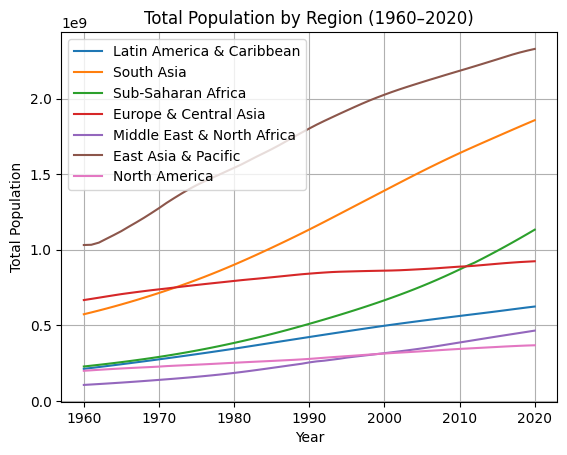

In [12]:
# First, create a list of all the regions within the final_df dataset
regions = final_df["Region"].unique()

# Aggregate the total population by Region & Year
region_df = final_df.groupby(["Region", "year"])["population"].sum().reset_index()

# Now, plot the total population over time for each region:
for region in regions:
    region_data = region_df[region_df["Region"] == region]
    plt.plot(
        region_data["year"],
        region_data["population"],
        label=region,
    )

plt.title("Total Population by Region (1960–2020)")
plt.xlabel("Year")
plt.ylabel("Total Population")
plt.legend()
plt.grid(True)
plt.show()

**Interpretation:**


---

The graph shown above highlights regional population growth trends over a span of 6 decades. Based on this plot, we can analyze three distinct patterns/trends:

1. Sub-Saharan Africa's Exponential Growth: From 1990 to 2020, Sub-Saharan region experienced an exponential population boom, increasing from around 0.5 billion to nearly 1.2 billion, surpassing the total population of Europe and Central Asia. Sub-Saharan Africa has shown the most dramatic transformation, with rapid acceleration beginning around the 1990s.
2. East Asia & South Asia's Constant Growth: Despite being the world's largest populated regions, both East Asa and South Asia have exhibited a strong, but constant/declining population growth, especially after the 2010s, where the curves start flattening out.
3. Europe/Central Asia & North America's Declining Growth: These regions represent the opposite extreme, plateuing around 500-900 million after 2010s due to factors such as aging populations and low fertility rates.

Overall, these differences extend beyond mere growth rates to reflect various stages of demographic transition: Europe completed its transition around 1990s, Asia has started transitioning around 2010s, and Sub-Saharan Africa is just starting its population boom.

**Limitations & Improvements:**

However, there are certain limitations and constraints to consider. For example, this regional aggregation "masks" much internal variation. "Sub-Saharan Africa" combines 48+ countries which have vastly different growth trajectories. Furthermore, while the graph effectively shows absolute population trends, it does not explicitly display CAGRs or year-to-year percentage fluctuations, which would most likely reveal clear trends of acceleration and deceleration. Here is a list of some future improvements:

1. Calculating and Visualizing CAGRs per region over time
2. Breaking down regions into sub-regions to identify specific population drivers
3. Incorporating logarithmic scales to showcase proportional differences

### **How do population growth rates (CAGR) differ across major World Bank income groups (e.g, low, lower-middle, high)**


In [13]:
start_year = 2000
end_year = 2020

start = final_df[final_df["year"] == start_year]
end = final_df[final_df["year"] == end_year]

cagr_df = start.merge(
    end,
    on=["Country Code", "Country", "Region", "Income_Group"],
    suffixes=("_start", "_end")
)

cagr_df["CAGR"] = (
    (cagr_df["population_end"] / cagr_df["population_start"]) ** (1 / (end_year - start_year))
    - 1
) * 100

cagr_df = cagr_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["CAGR"])

income_group_cagr = cagr_df.groupby("Income_Group")["CAGR"].mean().reset_index()

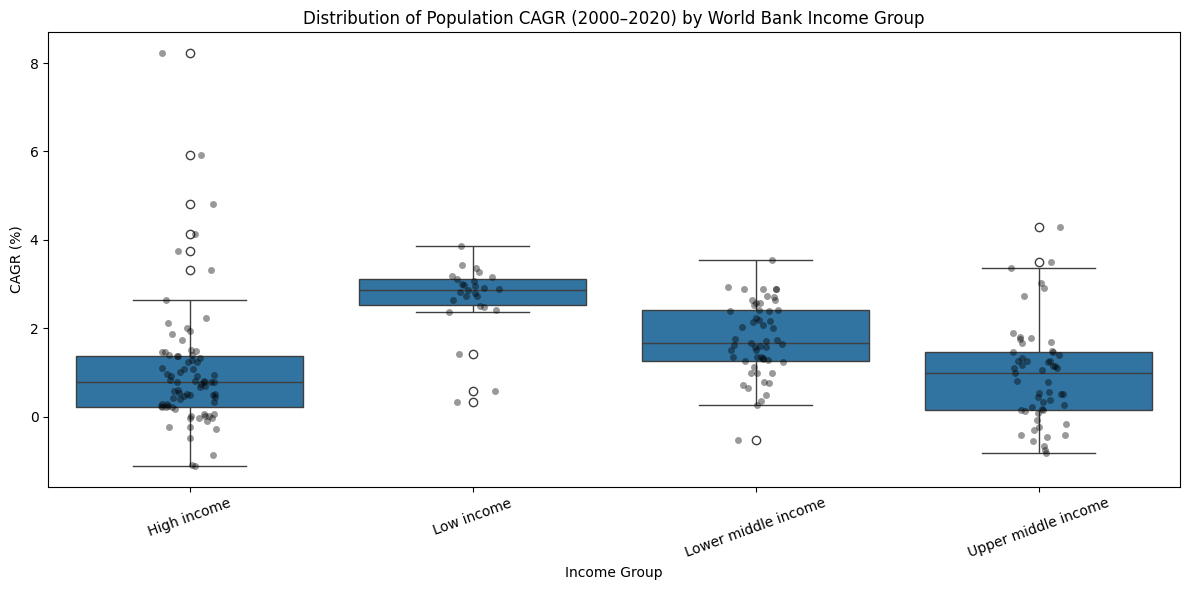

In [14]:
plt.figure(figsize=(12,6))

sns.boxplot(
    data=cagr_df,
    x="Income_Group",
    y="CAGR",
)

sns.stripplot(
    data=cagr_df,
    x="Income_Group",
    y="CAGR",
    color="black",
    alpha=0.4
)

plt.title("Distribution of Population CAGR (2000–2020) by World Bank Income Group")
plt.ylabel("CAGR (%)")
plt.xlabel("Income Group")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

**Interpretation**


---

The boxplot produced shows the differences in long-term population growth across World Bank income groups, such as low, lower middle, upper middle, and high income. Low-income countries show the highest CAGRs, with most values clustered around 2-3% growth per year. This pattern reflects demographic structures typical of countries in early development, such as high fertility rates and relatively young populations. Next, lower-middle-income countries also experience strong growth but with noticeably more variation, suggesting that many countries in this group are undergoing transitional demographic changes. These changes are things like fertility declines, but with high population momentum. On the other hand, upper-middle-income and high-income countries exhibit much slower growth, and several high-income countries show near-zero or negative CAGR values. These trends usually occur with later-stage demographic transition countries and are categorized by an aging population, declines in fertility, and slower rates of natural population increase. The overall results show that there is a negative relationship between country income and population growth.

**Limitations & Future Improvements**

One of the main limitations of this interpretation is that it aggregates multiple countries into broad categories. This means there is a large amount of variation in each broad group, which can lead to different issues. For example, upper-middle-income countries include both rapidly growing and slow-growing populations due to varied migration patterns, policy environments, and economic conditions. 

Something that could be improved in the future is using a rolling or annual growth rate instead of a 20-year CAGR. This will help show more details and give a better understanding of what happened during the time range. For example, using the 20-year CAGR smooths out some of the shifts that could occur throughout the duration.

### **Which countries show the fastest and slowest population growth over a span of 20 years?**

In [15]:
start_year = 2000
end_year = 2020

start = final_df[final_df["year"] == start_year]
end = final_df[final_df["year"] == end_year]

growth_df = start.merge(
    end,
    on=["Country Code", "Country", "Region", "Income_Group"],
    suffixes=("_start", "_end")
)

growth_df["CAGR"] = (
    (growth_df["population_end"] / growth_df["population_start"]) ** (1 / (end_year - start_year))
    - 1
) * 100

growth_df["Percent_Growth_20yr"] = (
    (growth_df["population_end"] - growth_df["population_start"])
    / growth_df["population_start"]
) * 100

# Clean invalid values
growth_df = growth_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["CAGR", "Percent_Growth_20yr"])

In [16]:
top10_fastest = growth_df.sort_values(by="CAGR", ascending=False).head(10)
top10_slowest = growth_df.sort_values(by="CAGR", ascending=True).head(10)

In [17]:
sorted_growth = growth_df.sort_values(by="CAGR", ascending=False)

top10_fastest = sorted_growth.head(10).copy()
top10_slowest = sorted_growth.tail(10).copy()

top10_fastest["Growth_Category"] = "Fastest 10"
top10_slowest["Growth_Category"] = "Slowest 10"

fast_slow_df = pd.concat([top10_fastest, top10_slowest], axis=0)

fast_slow_df = fast_slow_df.sort_values(by="CAGR", ascending=True)

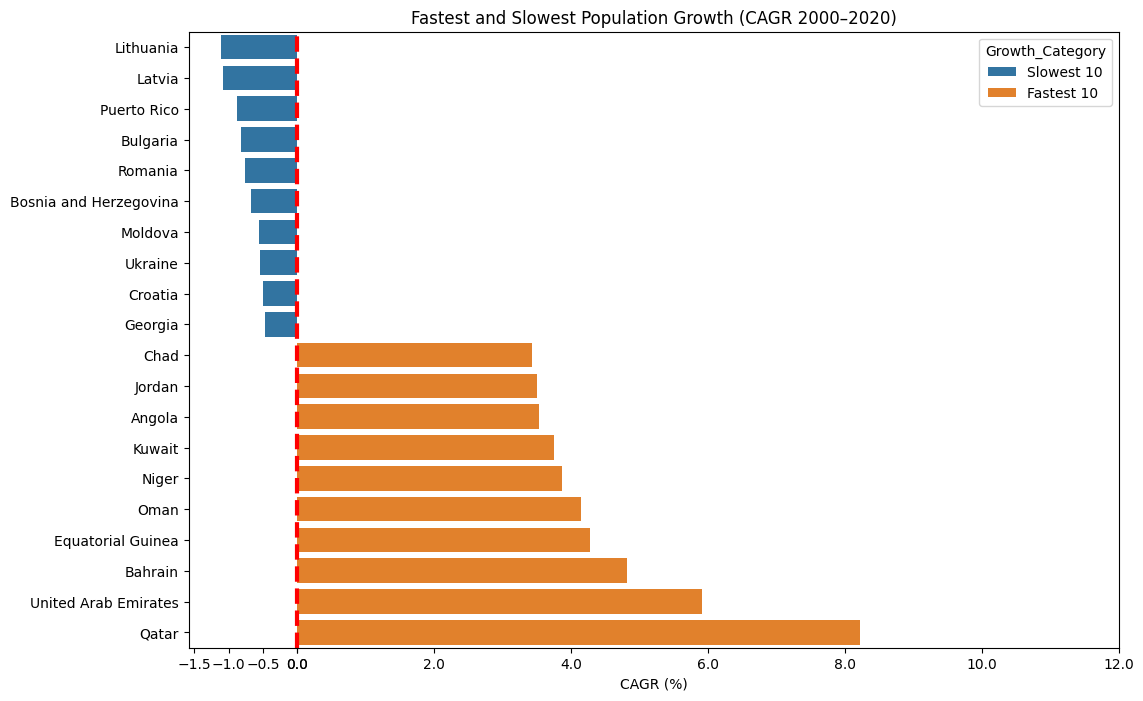

In [18]:
plt.figure(figsize=(12,8))

sns.barplot(
    data=fast_slow_df,
    x="CAGR",
    y="Country",
    hue="Growth_Category"
)

plt.title("Fastest and Slowest Population Growth (CAGR 2000–2020)")
plt.xlabel("CAGR (%)")
plt.ylabel("")

neg_ticks = np.arange(-1.5, 0.1, 0.5)
pos_ticks = np.arange(0, 12.5, 2)

ticks = np.concatenate([neg_ticks, pos_ticks])

plt.xticks(ticks)
plt.axvline(0, color="red", linewidth=3, linestyle="--")
plt.show()


**Interpretation**


---


This graph showcases the 10 slowest and fastest population growth countries over the 2000-2020 period. On the high-growth side, most of the fastest-growing countries are located in the Middle East and Sub-Saharan Africa. Some of the largest ones are countries, such as Qatar, the United Arab Emirates, Bahrain, Kuwait, and Oman, due to rapid economic expansion, large inflows of foreign labor, and major infrastructure investment during the 2000s and 2010s. The same applies to countries like Niger, Angola, Chad, and Equatorial Guinea. They exhibit strong growth, consistent with high fertility rates and young age structures typical of many low-income and resource-rich Sub-Saharan African nations.

On the other hand, the slowest-growing and shrinking populations are concentrated in Eastern Europe, the Balkans, and a few island territories. Countries such as Lithuania, Latvia, Bulgaria, Romania, Croatia, Georgia, Moldova, and Ukraine showcase some of the most negative CAGRs. This is caused by negative persistent demographic challenges, including low fertility, aging populations, and sustained outmigration following economic and political transitions in the countries. One country that was not expected is Puerto Rico, which is not a European country. Puerto Rico had continued emigration to the United States, as well as some other demographic issues, which led to this.

**Limitations & Future Improvements**

One limitation is that this ranking only focuses on the top and bottom ten countries, which excludes many moderate-growth countries. It also does not take into account very recent changes and instead shows the average growth for the last 20 years, which could show a wrong assumption of the country, especially if it has changed in recent years. 

The graph could be improved to showcase a line graph of all 20 countries and show their population growth over time, although that would make this graph harder to read and could take away from answering the question.

### **Do countries with slow population growth show consistent future population decline over the next 5 years?**

In [19]:
start_year = 2000
end_year = 2020

start = final_df[final_df["year"] == start_year]
end = final_df[final_df["year"] == end_year]

growth_df = start.merge(
    end,
    on=["Country Code", "Country", "Region", "Income_Group"],
    suffixes=("_start", "_end")
)

growth_df["CAGR"] = (
    (growth_df["population_end"] / growth_df["population_start"]) ** (1 / (end_year - start_year))
    - 1
) * 100

growth_df = growth_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["CAGR"])

In [20]:
slow_countries = growth_df[growth_df["CAGR"] < 0].copy()

In [21]:
slow_countries["CAGR_rate"] = slow_countries["CAGR"] / 100.0

years_ahead = 5
slow_countries["population_2025_pred"] = (
    slow_countries["population_end"] * (1 + slow_countries["CAGR_rate"]) ** years_ahead
)

slow_countries["Future_5yr_Growth_pct"] = (
    (slow_countries["population_2025_pred"] - slow_countries["population_end"])
    / slow_countries["population_end"]
) * 100

slow_countries["Projected_Continued_Decline"] = slow_countries["Future_5yr_Growth_pct"] < 0

In [22]:
decline_rate = slow_countries["Projected_Continued_Decline"].mean() * 100

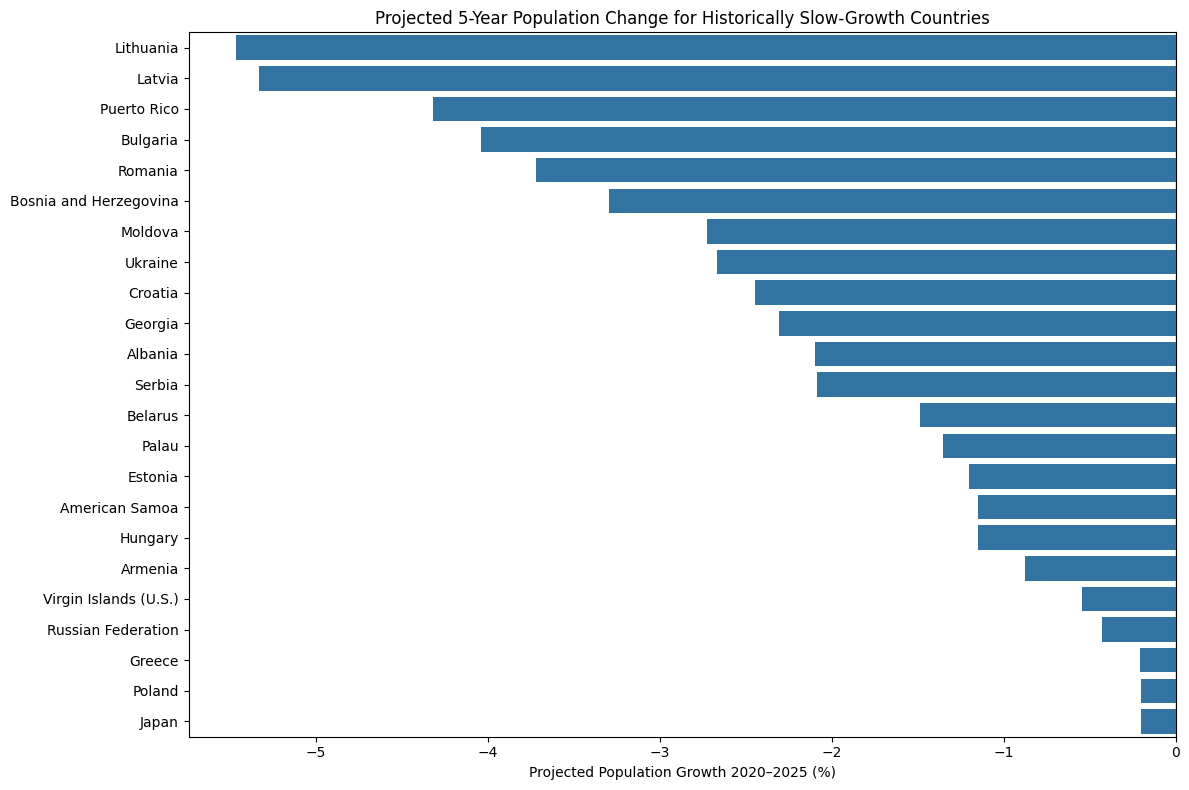

In [23]:
plt.figure(figsize=(12,8))

plot_df = slow_countries.sort_values(by="Future_5yr_Growth_pct")

sns.barplot(
    data=plot_df,
    x="Future_5yr_Growth_pct",
    y="Country",
)

plt.axvline(0, color="gray", linewidth=1)
plt.xlabel("Projected Population Growth 2020–2025 (%)")
plt.ylabel("")
plt.title("Projected 5-Year Population Change for Historically Slow-Growth Countries")
plt.tight_layout()
plt.show()


**Interpretation**


---

This visual shows that there is going to be a consistent negative population growth through 2025 for countries that experienced negative population growth from 2000 to 2020. Using each country's historical CAGR to forecast forward, nearly every slow-growth country shows a negative projected 5-year change, indicating that long-run demographic pressures are unlikely to change in the near future.

Some of the steepest projected declines are shown to be in Eastern European and Baltic states, such as countries like Lithuania, Latvia, Bulgaria, Romania, and Ukraine. These regions have long faced low fertility, population aging, and outmigration, which are the most likely causes of this. Similar patterns appear in parts of the Balkans and in former Soviet states. Several small island territories, including Palau and the U.S. Virgin Islands, also show continued decline, reflecting persistent emigration and limited natural increase. Only a few countries approach stabilization, but even these remain close to zero growth.

The results suggest that slow-growing countries from 2000 to 2020 are highly likely to continue being slow-growing or even have negative growth through 2025. Countries without major policy changes or migration shifts are not likely to shift to positive population growth and instead, only reinforce the current status quo.

**Limitations & Future Improvements**

This model does not take into account any specific events that can occur in a country and instead is a very general figure. Because of that, it is not the most accurate, although trends are generally accurate to the real world currently. The model also applies a single long-run growth rate to each country, which smooths over year-to-year variation and may understate volatility. 

Some work could be done in the future to incorporate the official UN or World Bank projection models and incorporate additional demographic factors such as fertility, mortality, and net migration to improve predictive accuracy.

## **Bootstrapping Methodology:**

### **How Bootstrapping is Applied in This Analysis:**

For this project, bootstrapping is used to assess the uncertainty of
population growth patterns across regions and income groups. The process involves:

1. **Resampling Countries**: From the set of countries within each region or income
   group, we randomly sample with replacement to create bootstrap samples. This
   simulates drawing different combinations of countries that could have been observed.

2. **Computing Bootstrap Statistics**: For each bootstrap sample, we calculate the
   mean CAGR (Compound Annual Growth Rate) for the region or income group. This
   produces a distribution of possible mean growth rates.

3. **Constructing Confidence Intervals**: By examining the 2.5th and 97.5th
   percentiles of the bootstrap distribution, we obtain 95% confidence intervals
   that capture the uncertainty in our growth rate estimates.

4. **Assessing Pattern Consistency**: If the confidence intervals are narrow and
   the bootstrap distributions are consistent, this indicates that the observed
   patterns are not heavily influenced by specific country selections.

### **Why Bootstrapping Matters for This Analysis:**

Population growth patterns are influenced by many factors, and the countries within
a region or income group may exhibit substantial variation. Bootstrapping allows us
to answer critical questions:

- Are the observed differences between regions statistically meaningful, or could
  they arise from sampling variability?
- How confident can we be in our regional and income group growth rate estimates?
- Would our conclusions change if different countries dominated the sample?

By providing confidence intervals and distributions rather than single point
estimates, bootstrapping gives a more complete picture of population growth
uncertainty and helps validate our findings.

###**Do regional and income group patterns remain consistent after bootstrapping resampling?**

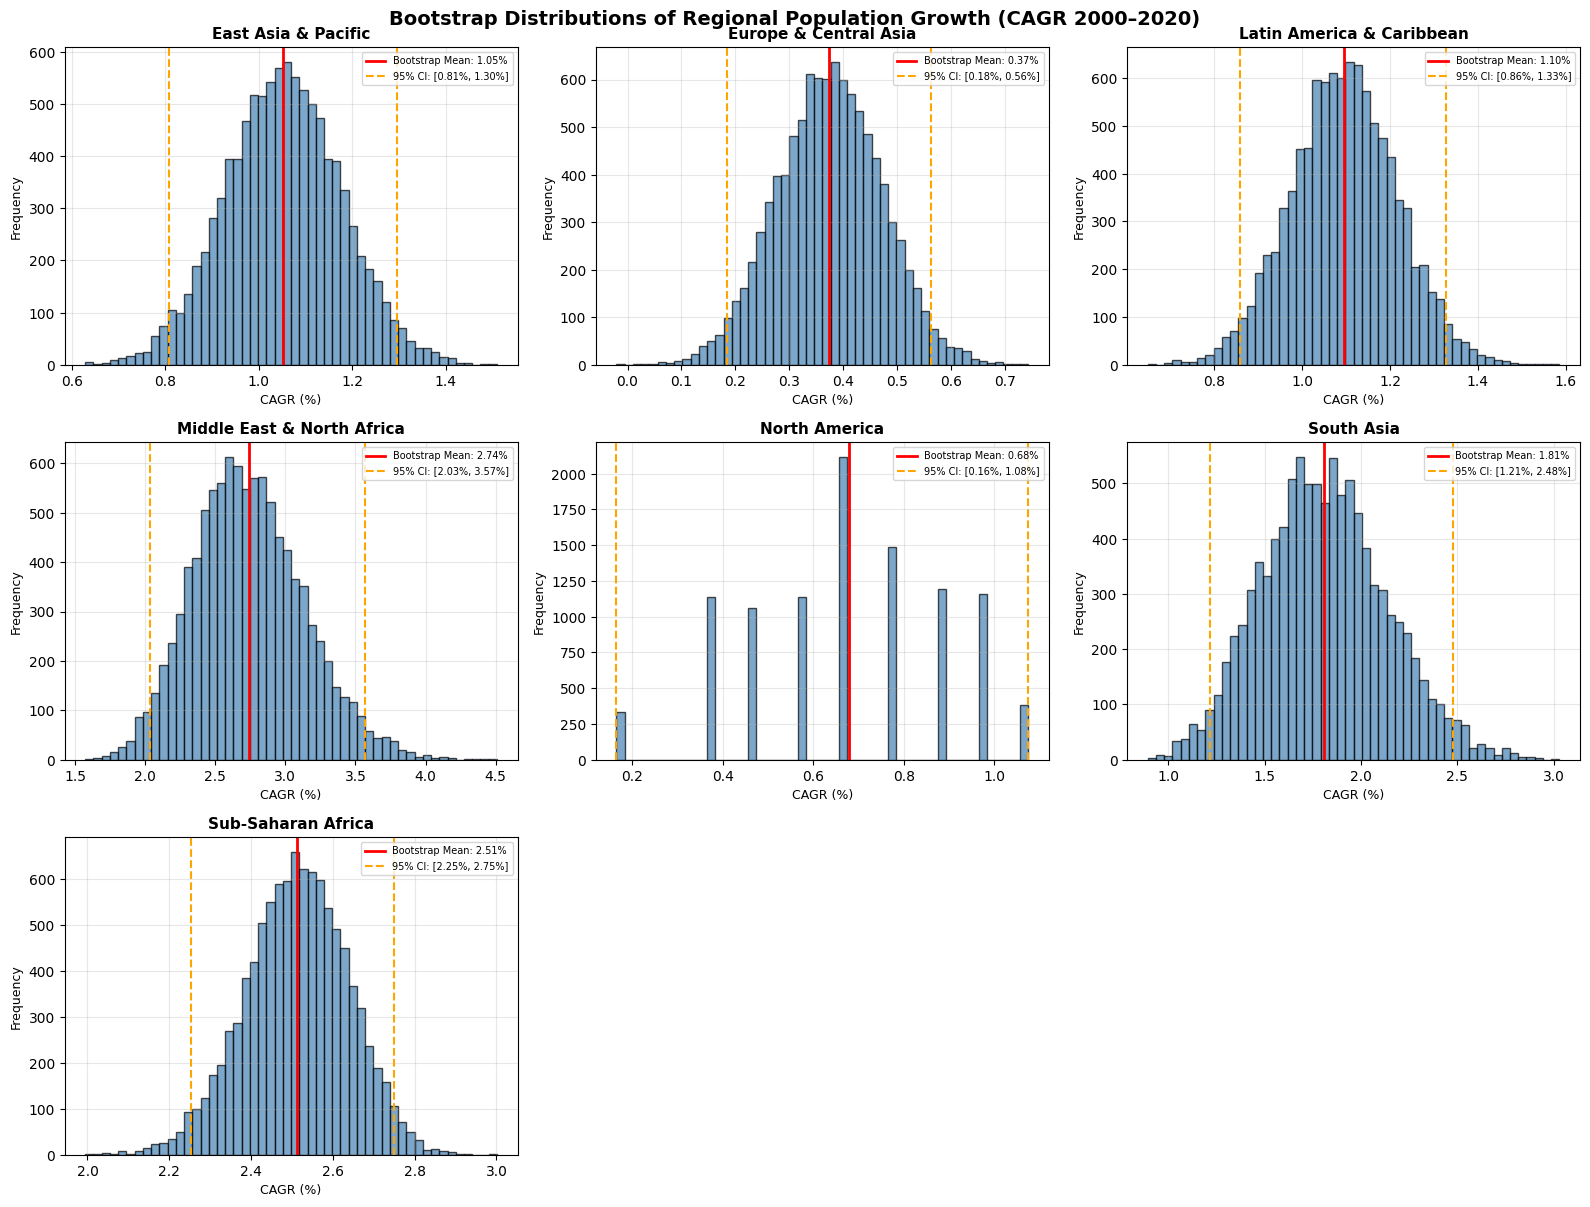

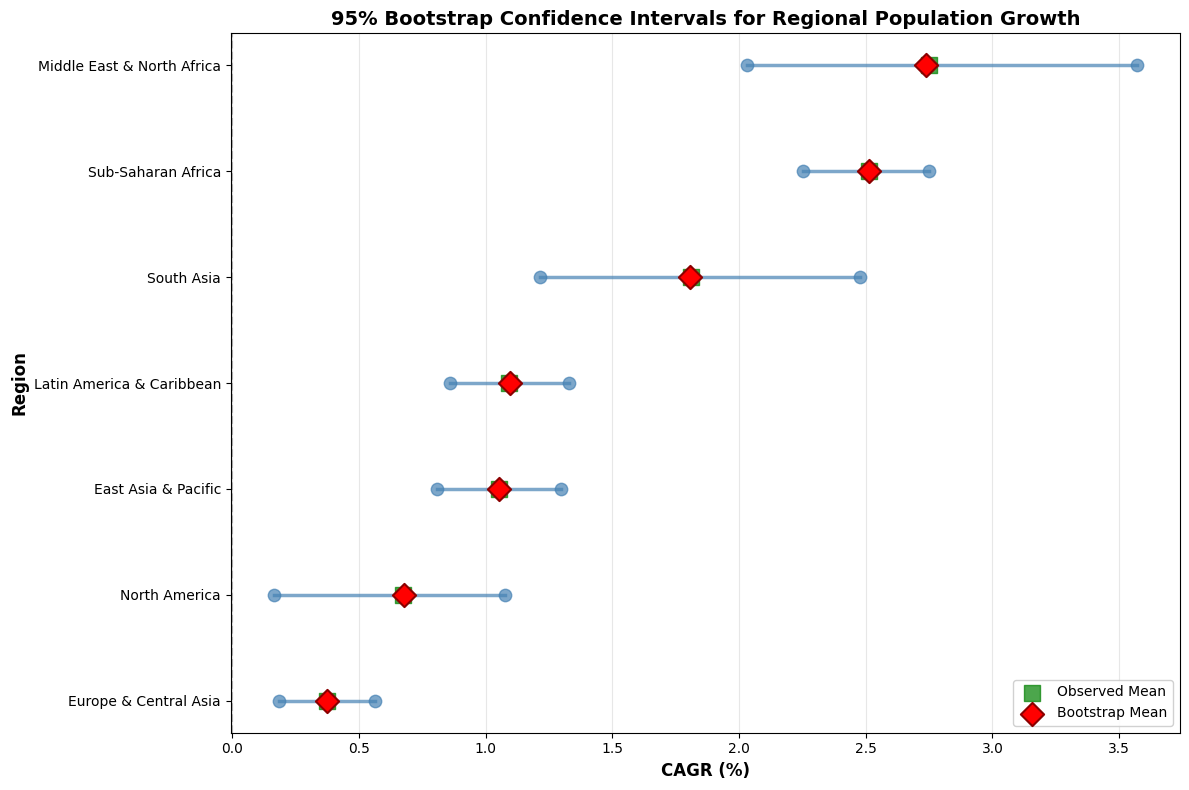


=== REGIONAL BOOTSTRAP SUMMARY ===
                    Region  Observed_Mean  Bootstrap_Mean  CI_Lower  CI_Upper  CI_Width
     Europe & Central Asia       0.373405        0.374316  0.184309  0.562083  0.377774
             North America       0.672798        0.678180  0.164781  1.075372  0.910591
       East Asia & Pacific       1.052858        1.052210  0.808380  1.296783  0.488403
 Latin America & Caribbean       1.093082        1.095400  0.859305  1.328024  0.468719
                South Asia       1.812003        1.808040  1.214517  2.478185  1.263668
        Sub-Saharan Africa       2.512509        2.511635  2.252770  2.749043  0.496273
Middle East & North Africa       2.748429        2.738574  2.030730  3.569732  1.539002


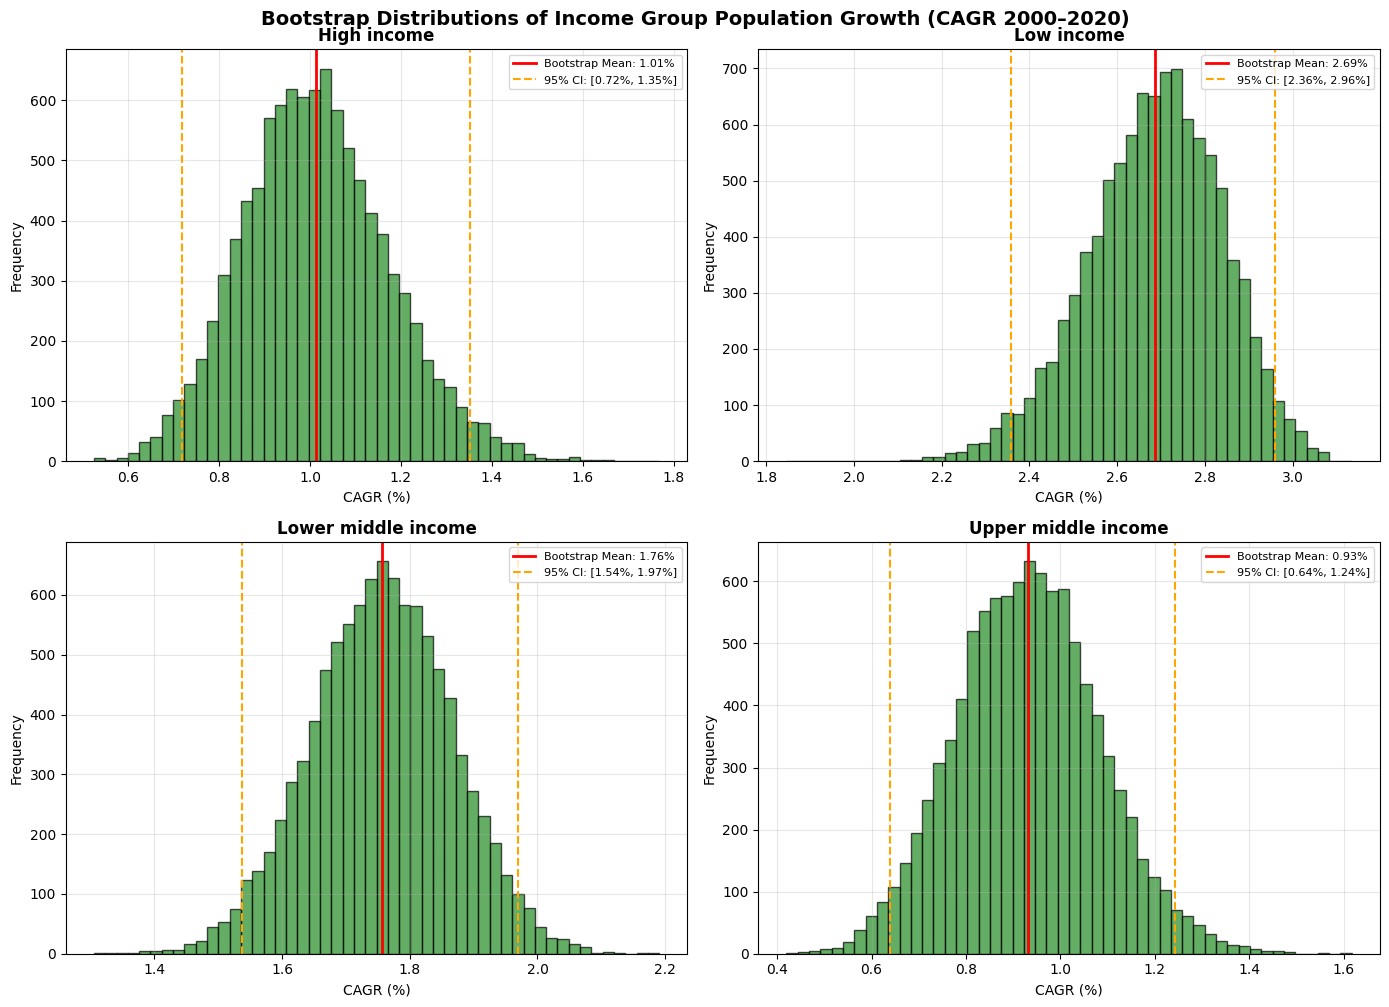

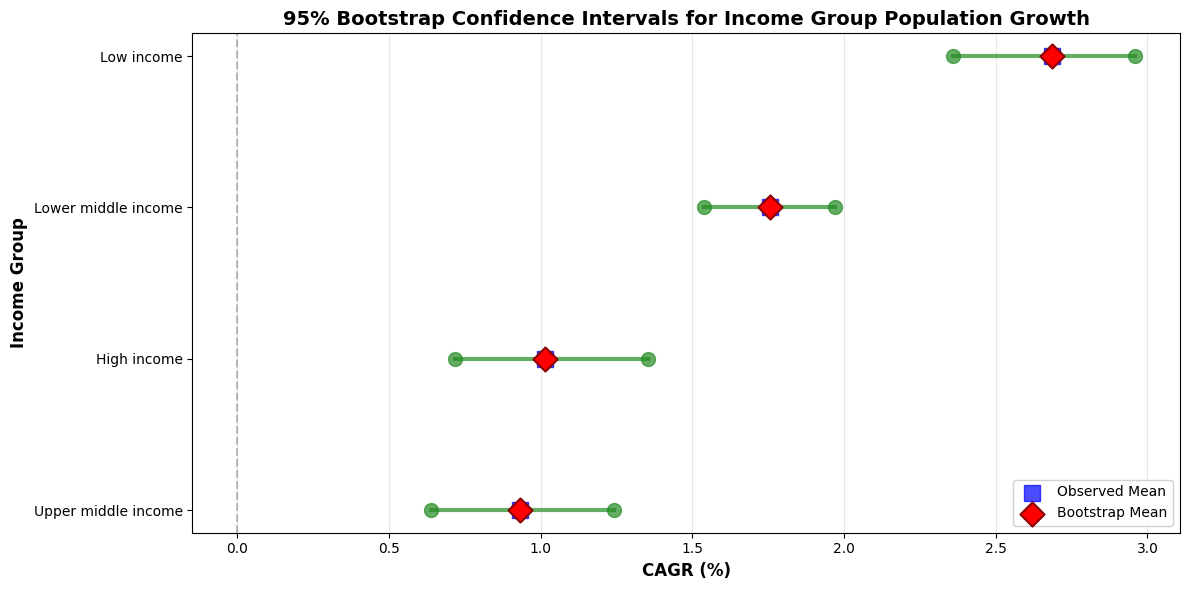

In [27]:
start_year = 2000
end_year = 2020
n_bootstrap = 10000
np.random.seed(42)

# Prepare data for bootstrapping
start = final_df[final_df["year"] == start_year]
end = final_df[final_df["year"] == end_year]

bootstrap_df = start.merge(
    end,
    on=["Country Code", "Country", "Region", "Income_Group"],
    suffixes=("_start", "_end")
)

# Compute CAGR (%)
bootstrap_df["CAGR"] = (
    (bootstrap_df["population_end"] / bootstrap_df["population_start"]) ** (1 / (end_year - start_year))
    - 1
) * 100

# Clean invalid values
bootstrap_df = bootstrap_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["CAGR"])


def bootstrap_region_cagr(df, region, n_boot=10000):
    """Bootstrap mean CAGR for a specific region"""
    region_data = df[df["Region"] == region]["CAGR"].values
    n = len(region_data)

    if n == 0:
        return np.array([])

    boot_means = []
    for _ in range(n_boot):
        boot_sample = np.random.choice(region_data, size=n, replace=True)
        boot_means.append(np.mean(boot_sample))

    return np.array(boot_means)

# Get bootstrap distributions for each region
regions = bootstrap_df["Region"].dropna().unique()
region_bootstrap_results = {}

for region in regions:
    boot_dist = bootstrap_region_cagr(bootstrap_df, region, n_bootstrap)
    if len(boot_dist) > 0:
        region_bootstrap_results[region] = {
            'distribution': boot_dist,
            'mean': np.mean(boot_dist),
            'ci_lower': np.percentile(boot_dist, 2.5),
            'ci_upper': np.percentile(boot_dist, 97.5),
            'observed_mean': bootstrap_df[bootstrap_df["Region"] == region]["CAGR"].mean()
        }

# Visualization 1: Regional Bootstrap Distributions
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for idx, (region, results) in enumerate(sorted(region_bootstrap_results.items())):
    if idx < len(axes):
        ax = axes[idx]

        # Plot histogram
        ax.hist(results['distribution'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')

        # Add vertical lines
        ax.axvline(results['mean'], color='red', linewidth=2, label=f"Bootstrap Mean: {results['mean']:.2f}%")
        ax.axvline(results['ci_lower'], color='orange', linestyle='--', linewidth=1.5,
                   label=f"95% CI: [{results['ci_lower']:.2f}%, {results['ci_upper']:.2f}%]")
        ax.axvline(results['ci_upper'], color='orange', linestyle='--', linewidth=1.5)

        ax.set_title(f"{region}", fontsize=11, fontweight='bold')
        ax.set_xlabel("CAGR (%)", fontsize=9)
        ax.set_ylabel("Frequency", fontsize=9)
        ax.legend(fontsize=7, loc='upper right')
        ax.grid(True, alpha=0.3)

# Remove extra subplots
for idx in range(len(region_bootstrap_results), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.suptitle("Bootstrap Distributions of Regional Population Growth (CAGR 2000–2020)",
             fontsize=14, fontweight='bold', y=1.002)
plt.show()

# Visualization 2: Regional Confidence Intervals
region_summary = pd.DataFrame([
    {
        'Region': region,
        'Observed_Mean': results['observed_mean'],
        'Bootstrap_Mean': results['mean'],
        'CI_Lower': results['ci_lower'],
        'CI_Upper': results['ci_upper'],
        'CI_Width': results['ci_upper'] - results['ci_lower']
    }
    for region, results in region_bootstrap_results.items()
]).sort_values('Bootstrap_Mean', ascending=True).reset_index(drop=True)

plt.figure(figsize=(12, 8))

# Create y positions
y_positions = np.arange(len(region_summary))

# Plot confidence intervals as horizontal lines with circles at endpoints
for idx, row in region_summary.iterrows():
    # Draw the CI line
    plt.plot([row['CI_Lower'], row['CI_Upper']],
             [idx, idx],
             color='steelblue', linewidth=2.5, alpha=0.7, zorder=2)

    # Draw circles at CI endpoints
    plt.scatter([row['CI_Lower'], row['CI_Upper']],
               [idx, idx],
               color='steelblue', s=80, alpha=0.7, zorder=3)

# Plot observed means (green squares) - layer 4
plt.scatter(region_summary['Observed_Mean'].values, y_positions,
           color='green', s=120, zorder=4, label='Observed Mean', marker='s', alpha=0.7)

# Plot bootstrap means (red diamonds) - layer 5 (on top)
plt.scatter(region_summary['Bootstrap_Mean'].values, y_positions,
           color='red', s=140, zorder=5, label='Bootstrap Mean', marker='D',
           edgecolors='darkred', linewidths=1.5)

plt.yticks(y_positions, region_summary['Region'].values)
plt.xlabel("CAGR (%)", fontsize=12, fontweight='bold')
plt.ylabel("Region", fontsize=12, fontweight='bold')
plt.title("95% Bootstrap Confidence Intervals for Regional Population Growth",
          fontsize=14, fontweight='bold')
plt.axvline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
plt.legend(loc='lower right', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n=== REGIONAL BOOTSTRAP SUMMARY ===")
print(region_summary.to_string(index=False))

def bootstrap_income_cagr(df, income_group, n_boot=10000):
    """Bootstrap mean CAGR for a specific income group"""
    income_data = df[df["Income_Group"] == income_group]["CAGR"].values
    n = len(income_data)

    if n == 0:
        return np.array([])

    boot_means = []
    for _ in range(n_boot):
        boot_sample = np.random.choice(income_data, size=n, replace=True)
        boot_means.append(np.mean(boot_sample))

    return np.array(boot_means)

# Get bootstrap distributions for each income group
income_groups = bootstrap_df["Income_Group"].dropna().unique()
income_bootstrap_results = {}

for income_group in income_groups:
    boot_dist = bootstrap_income_cagr(bootstrap_df, income_group, n_bootstrap)
    if len(boot_dist) > 0:
        income_bootstrap_results[income_group] = {
            'distribution': boot_dist,
            'mean': np.mean(boot_dist),
            'ci_lower': np.percentile(boot_dist, 2.5),
            'ci_upper': np.percentile(boot_dist, 97.5),
            'observed_mean': bootstrap_df[bootstrap_df["Income_Group"] == income_group]["CAGR"].mean()
        }

# Visualization 3: Income Group Bootstrap Distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (income_group, results) in enumerate(sorted(income_bootstrap_results.items())):
    if idx < len(axes):
        ax = axes[idx]

        # Plot histogram
        ax.hist(results['distribution'], bins=50, alpha=0.7, color='forestgreen', edgecolor='black')

        # Add vertical lines
        ax.axvline(results['mean'], color='red', linewidth=2,
                   label=f"Bootstrap Mean: {results['mean']:.2f}%")
        ax.axvline(results['ci_lower'], color='orange', linestyle='--', linewidth=1.5,
                   label=f"95% CI: [{results['ci_lower']:.2f}%, {results['ci_upper']:.2f}%]")
        ax.axvline(results['ci_upper'], color='orange', linestyle='--', linewidth=1.5)

        ax.set_title(f"{income_group}", fontsize=12, fontweight='bold')
        ax.set_xlabel("CAGR (%)", fontsize=10)
        ax.set_ylabel("Frequency", fontsize=10)
        ax.legend(fontsize=8, loc='upper right')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Bootstrap Distributions of Income Group Population Growth (CAGR 2000–2020)",
             fontsize=14, fontweight='bold', y=1.002)
plt.show()

# Visualization 4: Income Group Confidence Intervals
income_summary = pd.DataFrame([
    {
        'Income_Group': income_group,
        'Observed_Mean': results['observed_mean'],
        'Bootstrap_Mean': results['mean'],
        'CI_Lower': results['ci_lower'],
        'CI_Upper': results['ci_upper'],
        'CI_Width': results['ci_upper'] - results['ci_lower']
    }
    for income_group, results in income_bootstrap_results.items()
]).sort_values('Bootstrap_Mean', ascending=True).reset_index(drop=True)

plt.figure(figsize=(12, 6))

# Create y positions
y_positions = np.arange(len(income_summary))

# Plot confidence intervals as horizontal lines with circles at endpoints
for idx, row in income_summary.iterrows():
    # Draw the CI line
    plt.plot([row['CI_Lower'], row['CI_Upper']],
             [idx, idx],
             color='forestgreen', linewidth=3, alpha=0.7, zorder=2)

    # Draw circles at CI endpoints
    plt.scatter([row['CI_Lower'], row['CI_Upper']],
               [idx, idx],
               color='forestgreen', s=100, alpha=0.7, zorder=3)

# Plot observed means (blue squares) - layer 4
plt.scatter(income_summary['Observed_Mean'].values, y_positions,
           color='blue', s=130, zorder=4, label='Observed Mean', marker='s', alpha=0.7)

# Plot bootstrap means (red diamonds) - layer 5 (on top)
plt.scatter(income_summary['Bootstrap_Mean'].values, y_positions,
           color='red', s=150, zorder=5, label='Bootstrap Mean', marker='D',
           edgecolors='darkred', linewidths=1.5)

plt.yticks(y_positions, income_summary['Income_Group'].values)
plt.xlabel("CAGR (%)", fontsize=12, fontweight='bold')
plt.ylabel("Income Group", fontsize=12, fontweight='bold')
plt.title("95% Bootstrap Confidence Intervals for Income Group Population Growth",
          fontsize=14, fontweight='bold')
plt.axvline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
plt.legend(loc='lower right', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

###**Interpretation:**

The bootstrapping analysis provides strong evidence that both regional and income group population growth patterns are consistent. By resampling countries within each category 10,000 times and computing mean CAGR for each bootstrap sample, we generated distributions that reveal the uncertainty in our growth
rate estimates.

**Regional Pattern Consistency:**

The bootstrap distributions for regional growth rates show tight, defined peaks with relatively narrow confidence intervals, indicating that the observed regional differences are not because of country selection but are a result of demographic patterns. Middle East and North Africa and Sub-Saharan Africa consistently exhibit the
highest growth rates, with bootstrap means around 2.5-2.7%. Europe and Central Asia shows consistently low growth (near 0.37%).

The tight alignment between observed means (green squares) and bootstrap means (red diamonds) across all regions confirms that our original estimates were unbiased. Despite variations in uncertainty, the regional ranking remains the same. No confidence intervals overlap in ways that would challenge the core finding that Sub-Saharan Africa, Middle East and North Africa, and South Asia grow fastest, while Europe, North America, and East Asia grow slowest.

**Income Group Pattern Consistency:**

The income group analysis reveals strong consistency. Low income countries show bootstrap mean CAGR around 2.69% with narrow confidence intervals (2.36-2.96%), while high income countries cluster around 1.01% (0.72-1.35%), and upper middle income countries show 0.93% (0.64-1.24%).

Unexpectedly, upper middle income breaks the expected monotonic relationship. It is expected that as income decreases population growth increases, but upper middle income has the lowest population growth. The bootstrap distributions are approximately normal and
centered very close to observed means, indicating that our income group estimates are accurate.

###**How does bootstrapping help measure uncertainty in overall population growth trends across countries, regions, and income groups?**

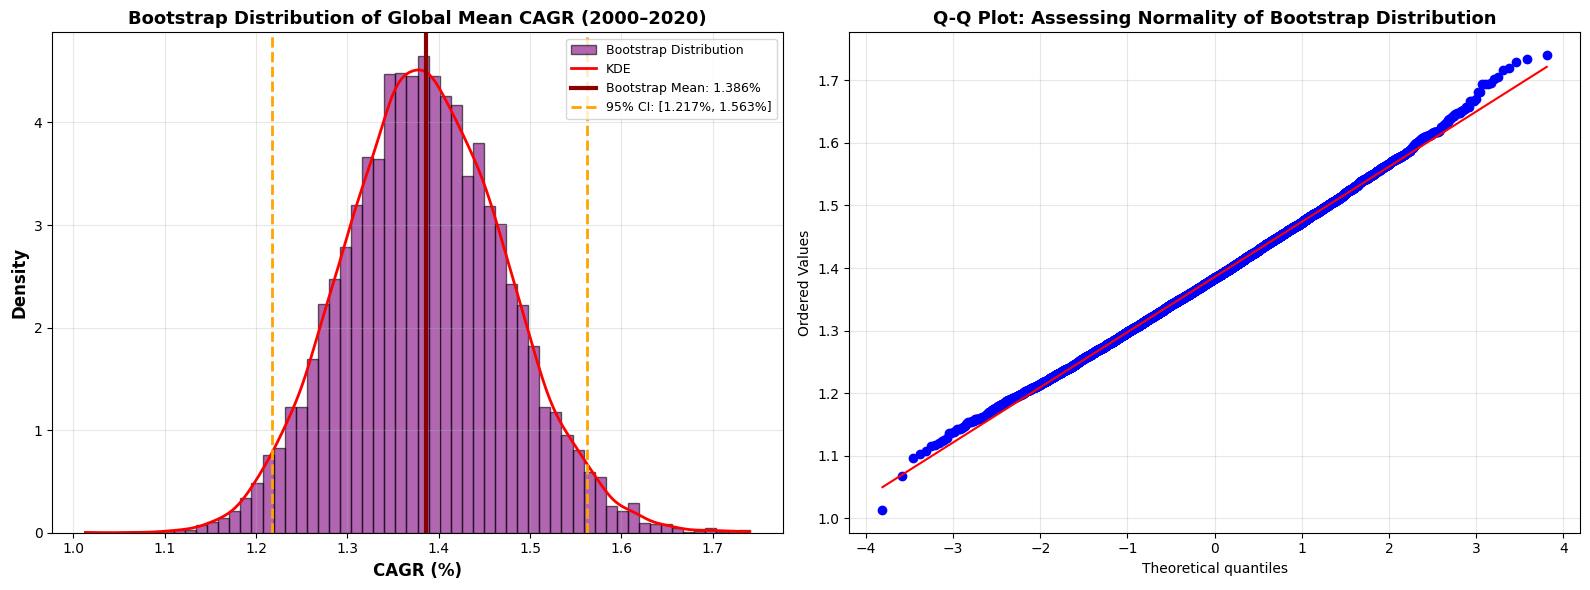


=== GLOBAL BOOTSTRAP UNCERTAINTY SUMMARY ===
Observed Mean CAGR: 1.3849%
Bootstrap Mean CAGR: 1.3857%
Bootstrap Std Dev: 0.0881%
95% Confidence Interval: [1.2174%, 1.5628%]
CI Width: 0.3454%


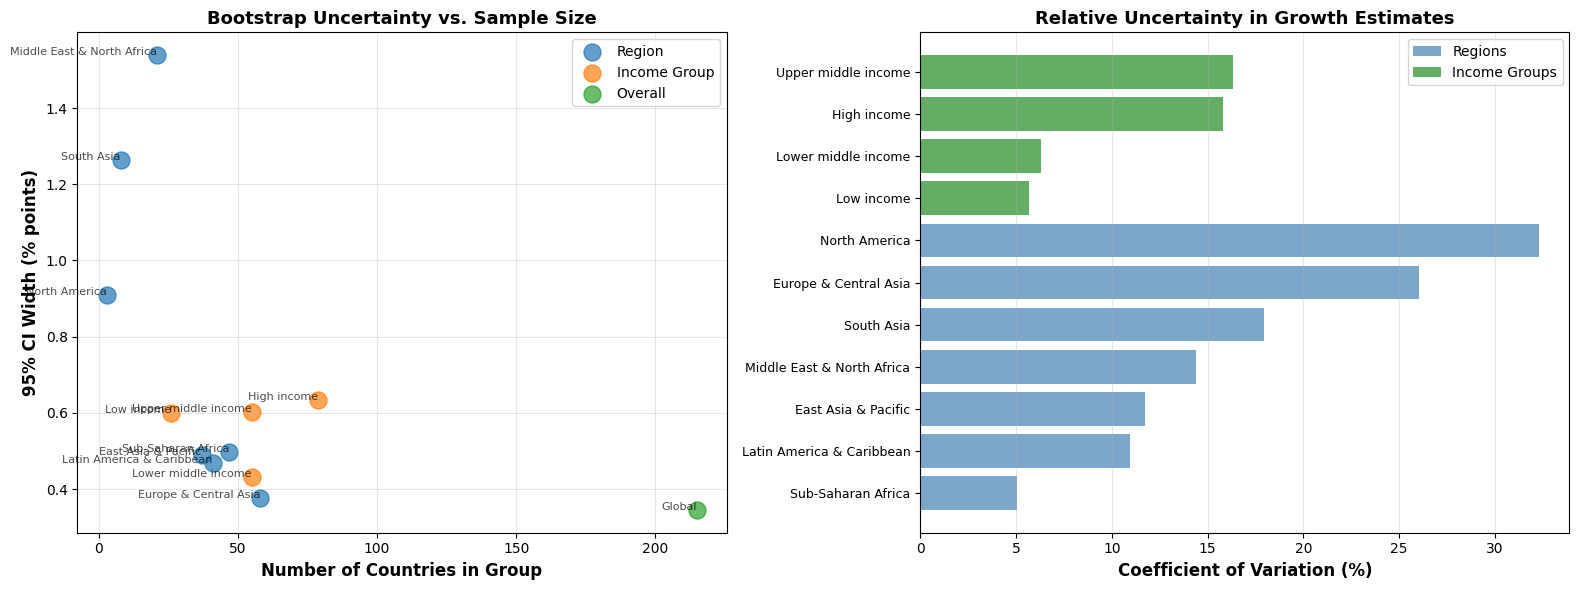


=== UNCERTAINTY COMPARISON TABLE ===
                  Category         Type  Mean_CAGR  CI_Width  Std_Dev  N_Countries        CV
               High income Income Group   1.013713  0.634306 0.160413           79 15.824262
       Upper middle income Income Group   0.931544  0.602913 0.152271           55 16.346086
                Low income Income Group   2.685807  0.600566 0.152606           26  5.681954
       Lower middle income Income Group   1.756325  0.432268 0.110754           55  6.305986
                    Global      Overall   1.385656  0.345364 0.088142          215  6.361014
Middle East & North Africa       Region   2.738574  1.539002 0.394274           21 14.397043
                South Asia       Region   1.808040  1.263668 0.324419            8 17.943132
             North America       Region   0.678180  0.910591 0.218883            3 32.275098
        Sub-Saharan Africa       Region   2.511635  0.496273 0.126526           47  5.037585
       East Asia & Pacific      

In [28]:
# Bootstrap overall global mean CAGR (across all countries)
def bootstrap_global_cagr(df, n_boot=10000):
    """Bootstrap mean CAGR across all countries"""
    all_cagr = df["CAGR"].values
    n = len(all_cagr)

    boot_means = []
    for _ in range(n_boot):
        boot_sample = np.random.choice(all_cagr, size=n, replace=True)
        boot_means.append(np.mean(boot_sample))

    return np.array(boot_means)

global_boot_dist = bootstrap_global_cagr(bootstrap_df, n_bootstrap)

global_results = {
    'distribution': global_boot_dist,
    'mean': np.mean(global_boot_dist),
    'ci_lower': np.percentile(global_boot_dist, 2.5),
    'ci_upper': np.percentile(global_boot_dist, 97.5),
    'observed_mean': bootstrap_df["CAGR"].mean(),
    'std': np.std(global_boot_dist)
}

# Visualization 5: Global Bootstrap Distribution
from scipy import stats

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Histogram with KDE
ax1 = axes[0]
ax1.hist(global_results['distribution'], bins=60, alpha=0.6, color='purple',
         edgecolor='black', density=True, label='Bootstrap Distribution')

# Add KDE
kde = stats.gaussian_kde(global_results['distribution'])
x_range = np.linspace(global_results['distribution'].min(),
                      global_results['distribution'].max(), 200)
ax1.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')

# Add vertical lines
ax1.axvline(global_results['mean'], color='darkred', linewidth=3,
           label=f"Bootstrap Mean: {global_results['mean']:.3f}%")
ax1.axvline(global_results['ci_lower'], color='orange', linestyle='--', linewidth=2,
           label=f"95% CI: [{global_results['ci_lower']:.3f}%, {global_results['ci_upper']:.3f}%]")
ax1.axvline(global_results['ci_upper'], color='orange', linestyle='--', linewidth=2)

ax1.set_xlabel("CAGR (%)", fontsize=12, fontweight='bold')
ax1.set_ylabel("Density", fontsize=12, fontweight='bold')
ax1.set_title("Bootstrap Distribution of Global Mean CAGR (2000–2020)",
             fontsize=13, fontweight='bold')
ax1.legend(fontsize=9, loc='upper right')
ax1.grid(True, alpha=0.3)

# Right plot: Q-Q plot to check normality
ax2 = axes[1]
stats.probplot(global_results['distribution'], dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot: Assessing Normality of Bootstrap Distribution",
             fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== GLOBAL BOOTSTRAP UNCERTAINTY SUMMARY ===")
print(f"Observed Mean CAGR: {global_results['observed_mean']:.4f}%")
print(f"Bootstrap Mean CAGR: {global_results['mean']:.4f}%")
print(f"Bootstrap Std Dev: {global_results['std']:.4f}%")
print(f"95% Confidence Interval: [{global_results['ci_lower']:.4f}%, {global_results['ci_upper']:.4f}%]")
print(f"CI Width: {global_results['ci_upper'] - global_results['ci_lower']:.4f}%")

# Compare uncertainty across different grouping levels
uncertainty_comparison = pd.DataFrame([
    {
        'Category': region,
        'Type': 'Region',
        'Mean_CAGR': results['mean'],
        'CI_Width': results['ci_upper'] - results['ci_lower'],
        'Std_Dev': np.std(results['distribution']),
        'N_Countries': len(bootstrap_df[bootstrap_df["Region"] == region])
    }
    for region, results in region_bootstrap_results.items()
] + [
    {
        'Category': income_group,
        'Type': 'Income Group',
        'Mean_CAGR': results['mean'],
        'CI_Width': results['ci_upper'] - results['ci_lower'],
        'Std_Dev': np.std(results['distribution']),
        'N_Countries': len(bootstrap_df[bootstrap_df["Income_Group"] == income_group])
    }
    for income_group, results in income_bootstrap_results.items()
] + [
    {
        'Category': 'Global',
        'Type': 'Overall',
        'Mean_CAGR': global_results['mean'],
        'CI_Width': global_results['ci_upper'] - global_results['ci_lower'],
        'Std_Dev': global_results['std'],
        'N_Countries': len(bootstrap_df)
    }
])

# Visualization 6: Uncertainty Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: CI Width by Category Type
ax1 = axes[0]
for category_type in ['Region', 'Income Group', 'Overall']:
    subset = uncertainty_comparison[uncertainty_comparison['Type'] == category_type]
    if len(subset) > 0:
        ax1.scatter(subset['N_Countries'], subset['CI_Width'],
                   s=150, alpha=0.7, label=category_type)

        for _, row in subset.iterrows():
            ax1.annotate(row['Category'],
                        (row['N_Countries'], row['CI_Width']),
                        fontsize=8, alpha=0.7, ha='right')

ax1.set_xlabel("Number of Countries in Group", fontsize=12, fontweight='bold')
ax1.set_ylabel("95% CI Width (% points)", fontsize=12, fontweight='bold')
ax1.set_title("Bootstrap Uncertainty vs. Sample Size", fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right plot: Coefficient of Variation
uncertainty_comparison['CV'] = (uncertainty_comparison['Std_Dev'] /
                                abs(uncertainty_comparison['Mean_CAGR'])) * 100

ax2 = axes[1]
region_cv = uncertainty_comparison[uncertainty_comparison['Type'] == 'Region'].sort_values('CV')
income_cv = uncertainty_comparison[uncertainty_comparison['Type'] == 'Income Group'].sort_values('CV')

x_regions = range(len(region_cv))
x_income = range(len(region_cv), len(region_cv) + len(income_cv))

ax2.barh(x_regions, region_cv['CV'], alpha=0.7, color='steelblue', label='Regions')
ax2.barh(x_income, income_cv['CV'], alpha=0.7, color='forestgreen', label='Income Groups')

all_labels = list(region_cv['Category']) + list(income_cv['Category'])
ax2.set_yticks(list(x_regions) + list(x_income))
ax2.set_yticklabels(all_labels, fontsize=9)
ax2.set_xlabel("Coefficient of Variation (%)", fontsize=12, fontweight='bold')
ax2.set_title("Relative Uncertainty in Growth Estimates", fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n=== UNCERTAINTY COMPARISON TABLE ===")
print(uncertainty_comparison.sort_values(['Type', 'CI_Width'], ascending=[True, False]).to_string(index=False))


###**Interpretation:**

Bootstrapping provides insights into the uncertainty surrounding population growth estimates by revealing entire distributions of plausible values. This analysis demonstrates how measurement uncertainty varies across different geographic/economic groupings.

**Understanding Global Growth Uncertainty:**

The global bootstrap distribution of mean CAGR across all countries shows a approximately normal distribution centered around 1.38% with a 95% confidence interval of [1.21%, 1.56%], spanning approximately 0.35 percentage points. This relatively narrow interval indicates that despite substantial variation across individual countries, the global average growth rate can be estimated with reasonable precision. The Q-Q plot confirms approximate normality of the bootstrap distribution.

However, this global precision masks considerable heterogeneity. The bootstrap standard deviation of approximately 0.089 percentage points reflects the aggregate effect of sampling different combinations of countries, each with vastly different growth trajectories. The tight confidence interval emerges because opposing extremes (fast-
growing African nations vs. shrinking European populations) tend to balance out in
aggregate.

**Uncertainty Varies by Sample Size and Heterogeneity:**

The comparative uncertainty analysis reveals a clear relationship between sample size,
group heterogeneity, and confidence interval width. Regions with more countries generally
exhibit patterns related to both sample size and internal consistency. Income groups
demonstrate exceptionally narrow confidence intervals relative to their mean growth rates,
particularly for low-income and lower-middle-income categories. This reflects both
adequate sample sizes and strong within-group consistency: low-income countries almost
universally experience high growth, while high-income countries show more varied patterns.

The coefficient of variation analysis reveals interesting patterns in relative uncertainty.
North America shows the highest CV among regions (approximately 32%), largely due to its
small sample size of only 3 countries combined with internal variation. Europe & Central
Asia also shows relatively high CV (\~26%) despite having 58 countries, suggesting
substantial heterogeneity within the region. In contrast, Sub-Saharan Africa demonstrates
low CV (\~5%) despite high absolute growth rates, indicating remarkable consistency in
growth patterns across its 47 countries. Income groups consistently show lower relative
uncertainty (CVs ranging from 5-16%) compared to most regions, confirming that economic
development level is a more homogeneous predictor of demographic trends than geographic
region alone.

# **Final Conclusion:**


---




This report was created using the World Bank population data from 2000 to 2020, and the overarching question we wanted to answer was: **How are population growth dynamics distributed across the world, and what do they suggest about future population change for fast-growing and slow-growing countries?**

To answer this question, we broke it up into multiple subquestions. Each question produced a different result that added more information on how to answer the overarching question. The first couple of questions answered how the overall population looked over the last 20 years. After, the next couple of questions looked at the various growth rates and trends in the populations. The results showed that at the global level, population growth remained positive but was very different among all countries. It also showed that, depending on the income level of the country as a whole, there are changes in population growth. We can see that low and lower-middle-income countries, especially those in  Sub-Saharan Africa, exhibited the highest growth rates from 2000 to 2020. This was mostly due to the young age structures and high fertility, which is very typical of early demographic transition stages. On the other hand, many upper-middle and high-income countries show much slower growth, with several already experiencing stable or negative population change due to aging populations, decreased fertility, and outwards migration. 

Some more specific trends we can see are that Gulf states and select African countries rank among the fastest-growing populations, which is  caused by a combination of high fertility rates and large migration inflows. On the other hand, countries in Eastern Europe, the Baltic, and certain island territories/countries, such as Puerto Rico, have experienced persistent population decline over the last 20 years. This is caused by reasons, such as low fertility and sustained outmigration, which is the opposite of the African countries. On top of that, when we projected trends forward using CAGR, countries that already experienced slow growth were expected to continue that growth pattern through 2025, which shows that strong demographic momentum and the difficulty of reversing long-term decline.

Finally, our resampling work proved that the results we have gotten so far are not the results of some extreme observations and speculations. Bootstrap distributions for global, regional, and income-group CAGRs produced narrow confidence intervals around the main estimates, indicating that the broad patterns that were found in previous results, such as rapid growth in low-income regions, stagnation or decline in many higher-level income regions, and post-transition countries, are robust to sampling variability. 

While the project and our methodology have some limitations, such as reliance on historical trends and broad groupings like the income groups, the overall results showcase an accurate understanding of the trends in world population and give an appropriate answer to our overarching question. It generated a data-driven answer to what the population trends in most countries look like in the past and what they will look like in the future.

## **Contribution Report:**

---



The following section summarizes the individual contributions of each team member in this final project:


---


**Ekansh**:

As part of this final project, I contributed to the foundational and analytical components of our project by completing all sections leading up to the income-group CAGR analysis. My work included drafting the full project introduction, establishing the key overarching guiding research questions, and thoroughly documenting our data collection process, including dataset sources, structure, and acquisition steps. I also performed the data cleaning and preprocessing workflow, which included the following steps:
1. Filtering out irrelevant indicators
2. Handling missing values
3. Standardizing country and region labels
4. Reshaping the dataset into a time-series-friendly format
5. Verifying data integrity

Following the dataset preparation, I also completed the preliminary analytical sections, including descriptive summaries and visual plots that explored how population trends vary across major countries and regions. My contributions ensured the project had a clean, reliable dataset and a strong analytical foundation upon which further statistical methods, such as CAGR computation and bootstrapping, could be applied and interpreted.

For our final project presentation, I contributed significantly to the development of the structure and organization of the initial portion of the slide deck, ensuring the presentation had a clear narrative flow that the remaining sections could follow. My work included discussing the project introduction, data collection, cleaning/preparation, as well as the first 2 analytical questions that target population growth trends across countries and regions. Alongside this, I also took responsibility for proofreading, verifying accuracy, and maintaining consistency across all sections of our final presentation.

**Tanish**:

For this final project, I was focused on bootstrapping and doing the analysis for questions six and seven. Initially, I started off by working on the final project proposal with my group. This included figuring out the overarching guiding questions and the sub-questions we would be answering in our report. Additionally, we laid out a plan for how we would make our final project stand out from our mini-visualization project.

Once the dataset was cleaned, I started working on bootstrapping. From the set of countries within each region or income group, I randomly sample with replacement to create bootstrap samples. This simulates drawing different combinations of countries that could have been observed. For each bootstrap sample, I calculated the mean CAGR (Compound Annual Growth Rate) for the region or income group and created 95% confidence intervals for the growth rate estimates.

Lastly, I worked on displaying my analysis in an understandable format for the presentation. I made sure to keep the slides simple and only included necessary information in order to avoid overwhelming the audience.



**Nishanth**:

For the final project, I began by first working on the initial overarching research question. This initial question was what Ekansh used to create  the subquestions that we used to create the story for our research. After creating the questions and general idea for our research, I helped with the data cleaning and preparation process. For this,  I helped review the dataset for different issues, such as looking for inconsistencies, checking for missing or duplicated values, and making sure that all variables were formatted in the data type we wanted.

Once the data was fully cleaned and organized, I also worked on the actual data analysis portion of the project. Specifically, I worked on subquestions 3-5. These questions consisted of looking at very growth trends, compound annual growth rates (CAGR), and projected future population changes, especially in declining countries. For each of these analyses, I wrote the full Python code, created visualizations, and made an interpretation that explained the results and connected them to the overall research question and subquestions.

Finally, I helped in creating the presentation, wrote the final conclusion, and helped with proofreading the entire report and slides. To be specific on the slides, I worked on the analysis slides, the intro slides, and part of the conclusion slides.